# MMPose预训练模型预测-Python API



## 导入工具包

In [70]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [71]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [72]:
img_path = 'data/multi-person.jpg'

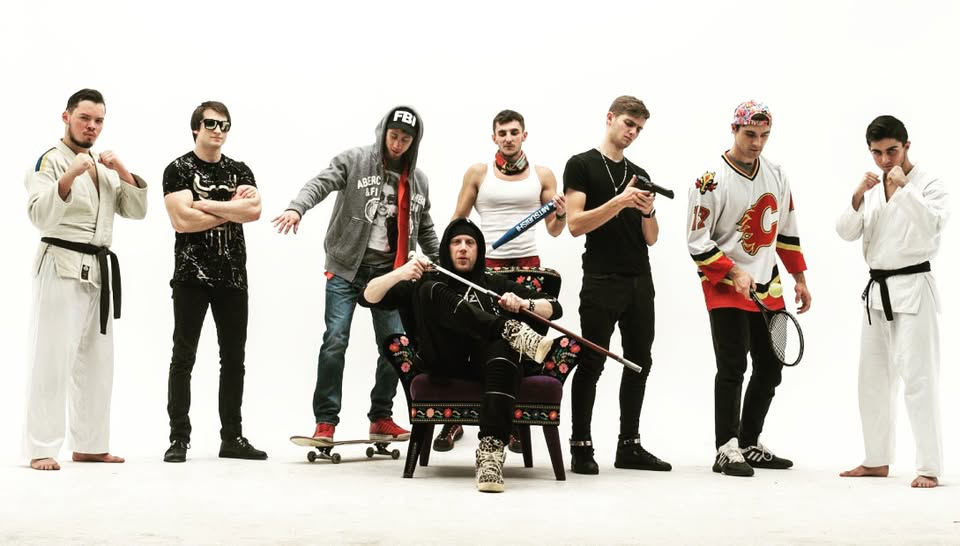

In [73]:
Image.open(img_path)

## 构建目标检测模型（任选一个运行）

In [74]:
# Faster R CNN
detector = init_detector(
    'mmpose/demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'mmdetection/checkpoint/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device,
)

Loads checkpoint by local backend from path: mmdetection/checkpoint/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).


In [75]:
# # RTMPose-Tiny
# # https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
# detector = init_detector(
#     'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
#     'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
#     device=device
# )

## 构建人体姿态估计模型

In [76]:
pose_estimator = init_pose_estimator(
    'mmpose/configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'mmpose/checkpoint/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: mmpose/checkpoint/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## 预测-目标检测

In [77]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

In [78]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

In [79]:
detect_result.keys()

['pred_instances', 'ignored_instances', 'gt_instances']

In [80]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [81]:
# help(detect_result.pred_instances)
# detect_result.pred_instances.keys()
# vars(detect_result.pred_instances)

In [82]:
# 置信度
detect_result.pred_instances.scores

tensor([0.7597, 0.7587, 0.7550, 0.7425, 0.7303, 0.7255, 0.7199, 0.6985, 0.6979,
        0.6978, 0.6944, 0.6942, 0.6882, 0.6871, 0.6866, 0.6817, 0.6795, 0.6776,
        0.6718, 0.6697, 0.6690, 0.6675, 0.6663, 0.6598, 0.6594, 0.6567, 0.6566,
        0.6561, 0.6520, 0.6505, 0.6504, 0.6473, 0.6426, 0.6413, 0.6409, 0.6401,
        0.6398, 0.6388, 0.6386, 0.6385, 0.6376, 0.6375, 0.6371, 0.6364, 0.6311,
        0.6309, 0.6308, 0.6294, 0.6292, 0.6255, 0.6230, 0.6222, 0.6208, 0.6129,
        0.6112, 0.6090, 0.6086, 0.6080, 0.6061, 0.6060, 0.6041, 0.6024, 0.6013,
        0.6012, 0.6005, 0.5968, 0.5965, 0.5963, 0.5952, 0.5946, 0.5944, 0.5943,
        0.5938, 0.5936, 0.5936, 0.5936, 0.5919, 0.5918, 0.5915, 0.5911, 0.5911,
        0.5901, 0.5900, 0.5893, 0.5883, 0.5871, 0.5851, 0.5847, 0.5844, 0.5838,
        0.5830, 0.5821, 0.5818, 0.5795, 0.5794, 0.5790, 0.5786, 0.5784, 0.5783,
        0.5781], device='cuda:0')

In [83]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
detect_result.pred_instances.bboxes

tensor([[339.6772, 429.7261, 450.0600, 458.7119],
        [537.5768, 311.9601, 586.8923, 382.5283],
        [468.0811, 365.6333, 577.4387, 478.4773],
        [367.2742, 438.4264, 413.3187, 456.2083],
        [352.2508, 438.6736, 401.7791, 459.8114],
        [396.5678, 240.2125, 432.9254, 289.8241],
        [249.1949, 433.6950, 351.4889, 465.9077],
        [419.1163, 358.1122, 653.8660, 457.7518],
        [449.4926, 291.6195, 600.1804, 374.6554],
        [351.3184, 431.7430, 411.4922, 443.5351],
        [376.4825, 421.3415, 496.1798, 478.4096],
        [409.2813, 245.1411, 438.0255, 263.3268],
        [348.8131, 386.2159, 502.6495, 445.5081],
        [622.5729, 167.1322, 660.7353, 204.8497],
        [474.2398, 436.5918, 505.2630, 498.3803],
        [506.9756, 198.3754, 587.1917, 226.0343],
        [431.2447, 397.2431, 459.9277, 460.2005],
        [517.7294, 363.7161, 603.2481, 463.3311],
        [663.1456, 297.1449, 819.3734, 364.3557],
        [403.1646, 395.0509, 695.5249, 471.7592],


## 置信度阈值过滤，获得最终目标检测预测结果

In [118]:
# 置信度阈值
CONF_THRES = 0.6

In [119]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [120]:
bboxes

array([[339.67715, 429.72607, 450.06003, 458.71188],
       [537.5768 , 311.96014, 586.89233, 382.5283 ],
       [468.08115, 365.63327, 577.4387 , 478.47733],
       [367.27417, 438.42642, 413.3187 , 456.20834],
       [396.56778, 240.21254, 432.92545, 289.82413],
       [249.19495, 433.69504, 351.48886, 465.90775],
       [449.49255, 291.61954, 600.18036, 374.65536],
       [351.31836, 431.74295, 411.49216, 443.53506],
       [376.4825 , 421.34146, 496.1798 , 478.40958],
       [409.28134, 245.1411 , 438.0255 , 263.3268 ],
       [348.8131 , 386.21585, 502.64954, 445.50815],
       [622.5729 , 167.13217, 660.7353 , 204.84966],
       [474.23984, 436.59177, 505.26303, 498.38028],
       [506.97562, 198.37544, 587.19165, 226.03426],
       [431.2447 , 397.2431 , 459.92773, 460.20047],
       [663.1456 , 297.14493, 819.3734 , 364.35568],
       [ 38.87025, 419.57355, 517.2737 , 466.43872],
       [464.3326 , 175.95007, 596.7712 , 468.59015],
       [892.9792 ,  95.86899, 960.     , 491.6

## 预测-关键点

In [121]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

In [122]:
len(pose_results)

38

In [123]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [124]:
data_samples.keys()

['pred_instances', 'pred_fields', '_pred_heatmaps', 'gt_instances']

## 预测结果-关键点坐标

In [125]:
# 每个人 17个关键点 坐标
data_samples.pred_instances.keypoints.shape

(38, 17, 2)

In [126]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[445.89192478, 421.94120127],
       [454.51558677, 410.44298559],
       [424.33276979, 414.75481647],
       [460.98333327, 378.82289249],
       [460.98333327, 378.82289249],
       [437.26826278, 434.8766939 ],
       [394.86859131, 352.23326874],
       [389.83812181, 355.10782266],
       [389.83812181, 357.2637381 ],
       [379.77718282, 417.62937039],
       [379.77718282, 420.50392431],
       [460.98333327, 377.38561553],
       [428.64460079, 456.4358483 ],
       [391.27539881, 355.10782266],
       [330.90976485, 357.2637381 ],
       [379.77718282, 417.62937039],
       [381.21445982, 417.62937039]])

## 预测结果-关键点热力图

In [127]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 546, 960)

In [128]:
idx_point = 6
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

In [129]:
heatmap.shape

(546, 960)

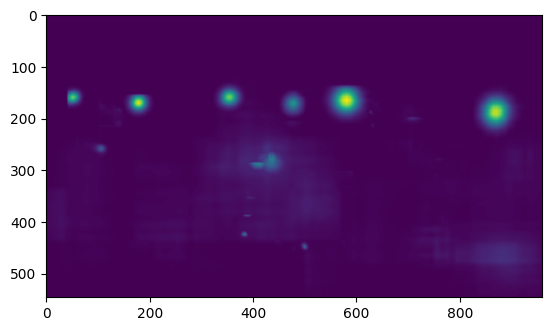

In [130]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [131]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

In [132]:
# 元数据
pose_estimator.dataset_meta

{'dataset_name': 'coco',
 'num_keypoints': 17,
 'keypoint_id2name': {0: 'nose',
  1: 'left_eye',
  2: 'right_eye',
  3: 'left_ear',
  4: 'right_ear',
  5: 'left_shoulder',
  6: 'right_shoulder',
  7: 'left_elbow',
  8: 'right_elbow',
  9: 'left_wrist',
  10: 'right_wrist',
  11: 'left_hip',
  12: 'right_hip',
  13: 'left_knee',
  14: 'right_knee',
  15: 'left_ankle',
  16: 'right_ankle'},
 'keypoint_name2id': {'nose': 0,
  'left_eye': 1,
  'right_eye': 2,
  'left_ear': 3,
  'right_ear': 4,
  'left_shoulder': 5,
  'right_shoulder': 6,
  'left_elbow': 7,
  'right_elbow': 8,
  'left_wrist': 9,
  'right_wrist': 10,
  'left_hip': 11,
  'right_hip': 12,
  'left_knee': 13,
  'right_knee': 14,
  'left_ankle': 15,
  'right_ankle': 16},
 'upper_body_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'lower_body_ids': [11, 12, 13, 14, 15, 16],
 'flip_indices': [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15],
 'flip_pairs': [(2, 1),
  (1, 2),
  (4, 3),
  (3, 4),
  (6, 5),
  (5, 6),
  (8, 7),
  

## 展示可视化效果

In [133]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [134]:
img_output.shape

(1092, 960, 3)

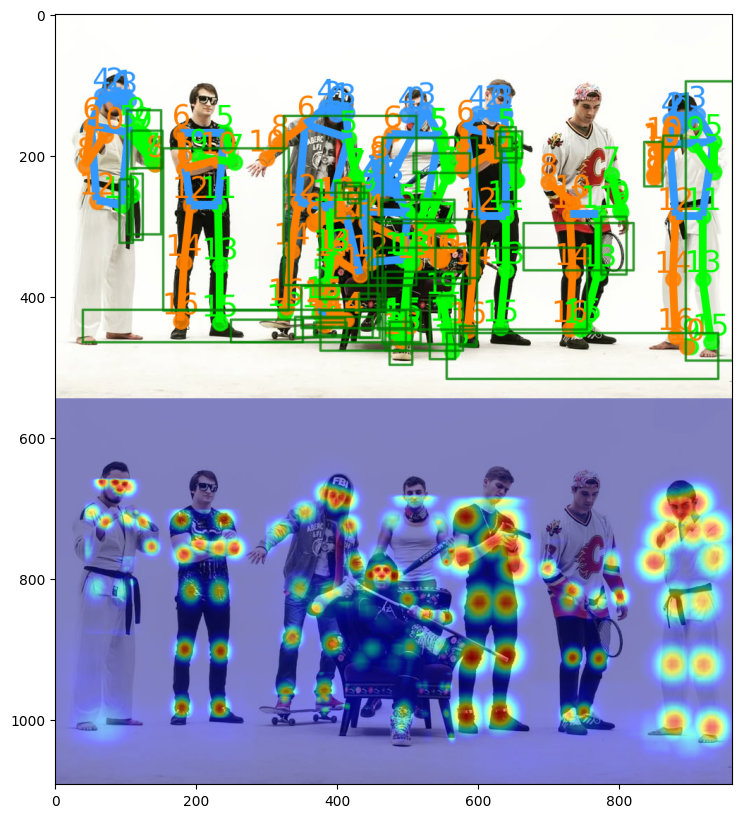

In [135]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()